In [30]:
import time
start = time.time()

In [31]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [32]:
df = pd.read_csv('octopus_energy_fb_comments.csv')
df.rename(columns={"fb_comment":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,Congratulations Laura
1,1,Rang u as my smart meter ain't working on scre...
2,2,"I just applied switched to Octopus , but can I..."
3,3,What do I need to do to get smart metres...
4,4,Could of phoned me


In [33]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [34]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()

In [35]:
list_data = df.comments.unique().tolist()

In [36]:
from sentence_transformers import SentenceTransformer

In [37]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [38]:
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [60]:
best_model = umap.UMAP(n_components=5,min_dist=0.0,metric='cosine').fit_transform(embeddings*10)

#n_neighbors=10, min_dist=0.0, 

In [61]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [62]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [63]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [64]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Accent')
    plt.show()

{-1: 8, 0: 6, 1: 9}


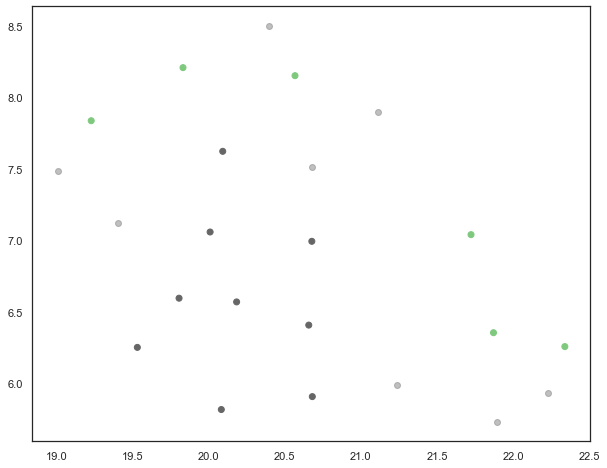

In [65]:
plot()

In [45]:
len(cluster)

736

In [46]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [47]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,sure be the millionth customer but miss phone ...
1,0,mine under tree come today enter apple pie cup...
2,1,lisa maureen jenkin see the tonight programme ...
3,2,clever stuff just need electric car for lol th...
4,3,you know when they say you couldn make well yo...
5,4,congratulation laura fantastic news well do xx...
6,5,sound like bit hawkward situation least she st...
7,6,still wait for money its nearly be year would ...
8,7,you guy have official app submit your secret c...
9,8,well do awesome company good energy company st...


In [48]:
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('apple cake', 0.5945), ('cake apple', 0.5927), ('apple cookie', 0.5734), ('use cake', 0.534), ('octocake apple', 0.5328), ('cake make', 0.5229), ('enter apple', 0.519), ('bake apple', 0.5182), ('apple tree', 0.5169), ('apple pie', 0.5168)]
   Bigram Cluster 2: 
[('tonight programme', 0.5373), ('programme night', 0.495), ('jenkin tonight', 0.4575), ('lisa maureen', 0.3941), ('clinton jamie', 0.3802), ('prentice william', 0.3754), ('night andrew', 0.3706), ('garala sophie', 0.3654), ('quiz night', 0.3625), ('lorna garnett', 0.3595)]
   Bigram Cluster 3: 
[('electric car', 0.4989), ('obvious electric', 0.4437), ('love electric', 0.4419), ('need electric', 0.438), ('electrician prefer', 0.4351), ('car expensive', 0.4259), ('idea electric', 0.4188), ('disposal battery', 0.4096), ('battery charge', 0.3966), ('think battery', 0.3942)]
   Bigram Cluster 4: 
[('scramble quiz', 0.4703), ('prize prize', 0.4609), ('cos prize', 0.459), ('thankyou quiz', 0.4554), ('thank winn

In [49]:
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('cake', 0.4674), ('apple', 0.4127), ('cookie', 0.3823), ('cranberry', 0.3551), ('cupcake', 0.3535), ('octocake', 0.3317), ('tree', 0.3217), ('pastry', 0.3146), ('chocolate', 0.3056), ('bake', 0.3032)]
   Unigram Cluster 2: 
[('programme', 0.3653), ('tonight', 0.361), ('liz', 0.3341), ('jess', 0.3151), ('lisa', 0.3146), ('garnett', 0.3064), ('lorna', 0.3016), ('prentice', 0.2925), ('coventry', 0.2889), ('nyks', 0.2824)]
   Unigram Cluster 3: 
[('battery', 0.36), ('electric', 0.3324), ('electrician', 0.3179), ('recyclable', 0.3067), ('expensive', 0.2896), ('car', 0.2829), ('renewable', 0.2607), ('essence', 0.2508), ('obvious', 0.2445), ('engine', 0.2424)]
   Unigram Cluster 4: 
[('prize', 0.3742), ('winner', 0.3654), ('award', 0.313), ('quiz', 0.2973), ('thankyou', 0.2766), ('win', 0.2732), ('lucky', 0.2702), ('submit', 0.2686), ('competetive', 0.2644), ('publish', 0.2548)]
   Unigram Cluster 5: 
[('excellent', 0.4828), ('enjoy', 0.4789), ('enjoyable', 0.4625), (

In [50]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['cake', 'apple', 'cookie', 'cranberry', 'cupcake', 'octocake', 'tree', 'pastry', 'chocolate', 'bake', 'apple cake', 'apple cookie', 'use cake', 'octocake apple', 'cake make', 'enter apple', 'bake apple', 'apple tree', 'apple pie']
   Cluster 2: 
['programme', 'tonight', 'liz', 'jess', 'lisa', 'garnett', 'lorna', 'prentice', 'coventry', 'nyks', 'tonight programme', 'programme night', 'jenkin tonight', 'lisa maureen', 'clinton jamie', 'prentice william', 'night andrew', 'garala sophie', 'quiz night', 'lorna garnett']
   Cluster 3: 
['battery', 'electric', 'electrician', 'recyclable', 'expensive', 'car', 'renewable', 'essence', 'obvious', 'engine', 'electric car', 'obvious electric', 'love electric', 'need electric', 'electrician prefer', 'car expensive', 'idea electric', 'disposal battery', 'battery charge', 'think battery']
   Cluster 4: 
['prize', 'winner', 'award', 'quiz', 'thankyou', 'win', 'lucky', 'submit', 'competetive', 'publish', 'scramble quiz', 'cos prize', 'th

In [51]:
end = time.time()
print(end - start)

198.51148557662964


In [52]:
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(array_text)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))

Top similar pairs:
cluster 22 	 cluster 23 	 similarity: 0.7456
cluster 17 	 cluster 22 	 similarity: 0.7185
cluster 1 	 cluster 22 	 similarity: 0.7096
cluster 15 	 cluster 22 	 similarity: 0.6984
cluster 14 	 cluster 16 	 similarity: 0.6942
cluster 15 	 cluster 17 	 similarity: 0.6942
cluster 17 	 cluster 23 	 similarity: 0.6770
cluster 1 	 cluster 23 	 similarity: 0.6749
cluster 13 	 cluster 14 	 similarity: 0.6522
cluster 16 	 cluster 20 	 similarity: 0.6491
cluster 14 	 cluster 18 	 similarity: 0.6275
cluster 1 	 cluster 17 	 similarity: 0.6045
cluster 15 	 cluster 23 	 similarity: 0.6022
cluster 1 	 cluster 15 	 similarity: 0.6020
cluster 1 	 cluster 14 	 similarity: 0.5954
cluster 16 	 cluster 21 	 similarity: 0.5747
cluster 20 	 cluster 21 	 similarity: 0.5703
cluster 13 	 cluster 17 	 similarity: 0.5537
cluster 10 	 cluster 18 	 similarity: 0.5367
cluster 8 	 cluster 14 	 similarity: 0.5322
cluster 15 	 cluster 18 	 similarity: 0.5294
cluster 8 	 cluster 18 	 similarity: 0.527